Author: Judit Lozano Gondolbeu

# Productivización de un modelo de análisis de siniestralidad
### Introducción

La parte final del ciclo de un proyecto de ciencia de datos es la productivización, monitorización del modelo, evaluación y toma de decisiones con respecto a la efectividad ese modelo.  

En esta práctica, continuaremos el ciclo de un proyecto de ciencia de datos a partir de la práctica_1, donde tras realizar un análisis exploratorio de los datos, procesado y estudio de varios modelos en base a unas métricas concretas, decidimos que el modelo que más se ajustaba a los criterios de selección para el objetivo que estabamos buscando, determinar si dado un accidente habrá o no habrá algún fallecido, era el LGBMClassifier().

Como parte de esta práctica, generaremos de nuevo el modelo para poder ejecutar y practicar con otras herramientas de python que permiten que el código esté más recogido y sea más eficiente a la hora de productivizar, por ejemplo, gracias a los métodos con pipelines.

## Generando el modelo de Machine Learning

Cargamos las librerias necesarias

### Libraries

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import warnings
import pickle
import category_encoders as ce
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from numpy import mean
import lightgbm as lgbm
from sklearn.feature_selection import SelectFromModel
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, roc_curve, precision_recall_curve,\
                             classification_report,  accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)

### Funciones que vamos a utilizar

In [14]:
def evaluate_model(y_test, y_pred, y_pred_proba = None):
    if y_pred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(y_test, y_pred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(y_test, y_pred)))
    print('Classification report: \n{}\n'.format(classification_report(y_test, y_pred)))
    print('Confusion matrix: \n{}\n'.format(confusion_matrix(y_test, y_pred)))

### Cargamos los Datos

In [11]:
#Leemos nuestra tabla de nuevo
df_data = pd.read_csv('df_data.csv')
df_data.head()

,C_MNTH,C_WDAY,C_HOUR,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SAFE,V_YEAR,C_YEAR,P_AGE,P_SEX,PP_CAR,TARGET
0,1,1,20,50,1,5,3,3,6,50,1990,1999,41,0,1,0
1,1,1,20,50,1,5,3,3,1,50,1987,1999,19,0,2,0
2,1,1,8,50,5,3,6,18,1,50,1986,1999,46,0,1,0
3,1,1,17,56,1,2,1,1,1,50,1984,1999,28,0,1,0
4,1,1,17,56,1,2,1,1,1,50,1991,1999,21,0,2,0


In [12]:
#quitamos la variable C_YEAR no disponible en el momento de hacer la predicción

df_data = df_data.drop('C_YEAR', axis=1)
df_data.head()

,C_MNTH,C_WDAY,C_HOUR,C_RCFG,C_WTHR,C_RSUR,C_RALN,C_TRAF,V_TYPE,P_SAFE,V_YEAR,P_AGE,P_SEX,PP_CAR,TARGET
0,1,1,20,50,1,5,3,3,6,50,1990,41,0,1,0
1,1,1,20,50,1,5,3,3,1,50,1987,19,0,2,0
2,1,1,8,50,5,3,6,18,1,50,1986,46,0,1,0
3,1,1,17,56,1,2,1,1,1,50,1984,28,0,1,0
4,1,1,17,56,1,2,1,1,1,50,1991,21,0,2,0


### Codificación de las variables
Applicaremos la siguiente codificación según grupo de variables:

In [13]:
#Grupos por encoding a realizar
numeric_features = ['V_YEAR', 'P_AGE']  
cat_features = list(set(df_data.drop('TARGET', axis=1).columns)-set(numeric_features))

In [14]:
df_data[cat_features] = df_data[cat_features].astype(object)

In [15]:
df_data.dtypes

C_MNTH    object
C_WDAY    object
C_HOUR    object
C_RCFG    object
C_WTHR    object
C_RSUR    object
C_RALN    object
C_TRAF    object
V_TYPE    object
P_SAFE    object
V_YEAR     int64
P_AGE      int64
P_SEX     object
PP_CAR    object
TARGET     int64
dtype: object

### Vemos los datos únicos

In [16]:
for col in df_data:
    print(df_data[col].name, df_data[col].unique())

C_MNTH [1 2 3 4 5 6 7 8 9 10 11 12 50]
C_WDAY [1 2 3 4 5 6 7 52]
C_HOUR [20 8 17 15 14 1 11 13 19 16 9 2 18 12 10 23 0 6 7 21 50 5 22 3 4]
C_RCFG [50 56 1 2 3 5 4 6 8 7 9 10]
C_WTHR [1 5 3 4 7 2 52 6 55]
C_RSUR [5 3 2 4 1 6 52 55 7 9 8]
C_RALN [3 6 1 52 2 5 4 55]
C_TRAF [3 18 1 50 6 10 5 4 11 56 7 8 16 17 2 13 15 9 12]
V_TYPE [6 1 11 50 20 17 7 8 56 9 22 14 23 5 16 18 19 54 10 21]
P_SAFE [50 2 1 13 54 12 9 56 10 11]
V_YEAR [1990 1987 1986 1984 1991 1992 1997 1993 1985 1988 1994 1995 1998 1989
 2100 1996 1983 1999 1965 1977 1978 2102 1968 1981 1979 1976 1972 2000
 1982 1975 1973 1974 1980 1967 1970 1971 1962 1969 1966 1945 1963 1960
 1950 1964 1959 1955 1958 1903 1909 1949 1923 1961 1914 1908 1953 1906
 1939 1925 1948 1938 1907 1952 1904 1917 1912 1944 1956 1930 1931 1951
 1946 1947 1957 1954 1943 1901 1937 1905 1935 1926 1941 1932 1920 1933
 1919 1915 1929 1928 2001 1913 1940 1927 2002 1916 1942 1918 2003 1924
 1922 1934 2004 2005 2006 2007 2008 1911 2009 2010 2011 1936 2012 1910
 1921

### Dividimos el dataset en train y test
Dividimos el dataset en train y test manteniendo la proporción de la variable objetivo en las dos partes (separación estratificada)

In [17]:
#Definimos train y target
target = df_data[['TARGET']]
train = df_data.drop('TARGET', axis = 1)

In [18]:
all_features = train.columns
all_features

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_RCFG', 'C_WTHR', 'C_RSUR', 'C_RALN',
       'C_TRAF', 'V_TYPE', 'P_SAFE', 'V_YEAR', 'P_AGE', 'P_SEX', 'PP_CAR'],
      dtype='object')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train, target, stratify=target, shuffle=True, test_size=0.20, random_state=0)
#comprobación de la estratificación
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

TARGET
0         0.985431
1         0.014569
dtype: float64
TARGET
0         0.985432
1         0.014568
dtype: float64


### Preparación de los pasos para la utilización de la Pipeline_1: Con datos desbalanceados

In [10]:
#1st Transformer
trf1 = ColumnTransformer([
        ('catboost',ce.CatBoostEncoder(),cat_features)])

In [11]:
#2nd Transformer: Scaling
trf2 = ColumnTransformer([('scaler', StandardScaler(),slice(0,len(X_train.columns)))
                         ])

In [12]:
#5th Model
trf3 = lgbm.LGBMClassifier()

In [13]:
pipe = Pipeline([
    ('trf1', trf1),
    ('trf2', trf2),
    ('trf3', trf3)
])

pipe.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('catboost', CatBoostEncoder(),
                                                  ['P_SAFE', 'C_TRAF', 'C_RCFG',
                                                   'V_TYPE', 'P_SEX', 'C_RALN',
                                                   'C_MNTH', 'C_RSUR', 'PP_CAR',
                                                   'C_HOUR', 'C_WDAY',
                                                   'C_WTHR'])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 14, None))])),
                ('trf3', LGBMClassifier())])

In [15]:
lgb_pred = pipe.predict(X_test)
lgb_pred_proba = pipe.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.8073576013533662
Accuracy of the model: 0.9854499005371756

Classification report: 
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    773779
           1       0.64      0.00      0.01     11439

    accuracy                           0.99    785218
   macro avg       0.81      0.50      0.50    785218
weighted avg       0.98      0.99      0.98    785218


Confusion matrix: 
[[773761     18]
 [ 11407     32]]



Se observa como el modelo no predice casi ningún caso positivo ya que no tiene suficientes datos para aprender y poder ser efectivo detectando siniestralidades.

### Problema de desbalanceo de datos

Para solventar este problema probaremos con la técnica SMOTE.

### SMOTE
SMOTE realiza un oversample de la clase minoritaria segun la configuracion que le demos (Ej: strategy, k-values). Por defecto, el K-value es 5 pero en este caso usaremos un k-value = 6 como ya discutimos en la practica_1. 

In [16]:
over = SMOTE(sampling_strategy=0.1, k_neighbors=6)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('trf1', trf1),('trf2', trf2), 
         ('over', over), ('under', under), ('trf3', trf3)]
modelo = Pipeline(steps=steps)
modelo.fit(X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('catboost', CatBoostEncoder(),
                                                  ['P_SAFE', 'C_TRAF', 'C_RCFG',
                                                   'V_TYPE', 'P_SEX', 'C_RALN',
                                                   'C_MNTH', 'C_RSUR', 'PP_CAR',
                                                   'C_HOUR', 'C_WDAY',
                                                   'C_WTHR'])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 14, None))])),
                ('over', SMOTE(k_neighbors=6, sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('trf3', LGBMClassifier())])

In [17]:
lgb_pred = modelo.predict(X_test)
lgb_pred_proba = modelo.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.7720505280344286
Accuracy of the model: 0.9750986350287436

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    773779
           1       0.12      0.11      0.11     11439

    accuracy                           0.98    785218
   macro avg       0.55      0.55      0.55    785218
weighted avg       0.97      0.98      0.97    785218


Confusion matrix: 
[[764412   9367]
 [ 10186   1253]]



En este caso, se observa como el modelo ya predice un mayor número de casos positivos sin optimizar el modelo y aplicando sólo la técnica de sintetizado SMOTE combinadola con un ligero undersampling. Aunque también se observa que el modelo se equivoca más, en este proyecto el coste de equivocarse en los casos positivos no lo vamos a penalizar ya que nos interesa que el modelo sea capaz de captar el suficiente numero de siniestralidades para cubrir aquellos casos positivos que no se han detectado. 

### Regularización Ridge: Reducción de la dimensionalidad

Para evitar problemas de tiempo en la ejecución de los modelos debido al tamaño del dataset, procederemos a reducir la dimensionalidad de nuestro dataset en cuanto a las variables del mismo:

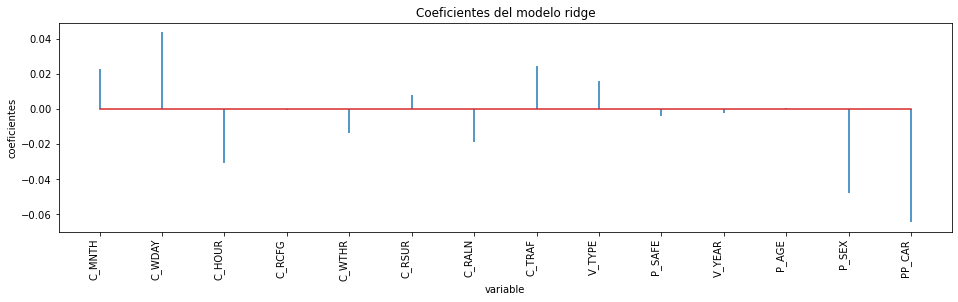

In [18]:
sel_ridge = SelectFromModel(LogisticRegression(C=1, penalty='l2'), threshold = 0.01)
steps = [('trf1', trf1),('trf2', trf2), 
         ('over', over), ('under', under), ('sel_ridge', sel_ridge)]
modelo = Pipeline(steps=steps)
modelo.fit(X_train, y_train)



sel_ridge.fit(X_train, y_train)
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': sel_ridge.estimator_.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(16, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo ridge');

In [19]:
sel_ridge.get_support()
selected_feat = X_train.columns[sel_ridge.get_support()]

In [20]:
selected_feat

Index(['C_MNTH', 'C_WDAY', 'C_HOUR', 'C_WTHR', 'C_RALN', 'C_TRAF', 'V_TYPE',
       'P_SEX', 'PP_CAR'],
      dtype='object')

In [21]:
print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))

total features: 14
selected features: 9


In [22]:
selected_feat.tolist()

['C_MNTH',
 'C_WDAY',
 'C_HOUR',
 'C_WTHR',
 'C_RALN',
 'C_TRAF',
 'V_TYPE',
 'P_SEX',
 'PP_CAR']

In [23]:
#Grupos por encoding a realizar con las variables más relevantes según Ridge
cat_features = selected_feat.tolist()

In [24]:
final_features = cat_features

In [25]:
final_X_train = X_train[final_features]

In [26]:
X_test = X_test[final_features]

Aplicando el modelo de Ridge, llevaremos a producción el modelo entrenado con las 9 variables seleccionadas por esta técnica de reducción de variables. Esta técnica, tiene un coste de perdida de información y por lo tanto la precisión predictoria del modelo final no será tan buena pero a su vez, el modelo productivizado será más ligero y el coste computacional será menor.

### Entreno del Modelo con la dimensionalidad reducida

In [27]:
#1st Transformer
trf1 = ColumnTransformer([
        ('catboost',ce.CatBoostEncoder(),cat_features)])

In [28]:
#2nd Transformer: Scaling
trf2 = ColumnTransformer([('scaler', StandardScaler(),slice(0,len(X_train.columns)+1))
                         ])

In [29]:
#3rd Model
trf3 = lgbm.LGBMClassifier()

In [30]:
over = SMOTE(sampling_strategy=0.1, k_neighbors=6)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('trf1', trf1),('trf2', trf2), 
         ('over', over), ('under', under), ('trf3', trf3)]
modelo = Pipeline(steps=steps)
modelo.fit(final_X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('catboost', CatBoostEncoder(),
                                                  ['C_MNTH', 'C_WDAY', 'C_HOUR',
                                                   'C_WTHR', 'C_RALN', 'C_TRAF',
                                                   'V_TYPE', 'P_SEX',
                                                   'PP_CAR'])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 15, None))])),
                ('over', SMOTE(k_neighbors=6, sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('trf3', LGBMClassifier())])

In [31]:
lgb_pred = modelo.predict(X_test)
lgb_pred_proba = modelo.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.7553010249334864
Accuracy of the model: 0.9750298643179346

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    773779
           1       0.08      0.07      0.07     11439

    accuracy                           0.98    785218
   macro avg       0.53      0.53      0.53    785218
weighted avg       0.97      0.98      0.97    785218


Confusion matrix: 
[[764846   8933]
 [ 10674    765]]



Se observa como el modelo ha perdido algo de precisión en cuanto al acierto de casos positivos. Sin embargo, en este caso, vamos a valorar más el trabajar con un modelo de dimensiones reducidas y trataremos de recuperar un cierto grado de precisión gracias a la optimización del modelo mediante la búsqueda de los hiperparámetros que mejor resultado nos den.

### Busqueda de hiperparámetros

In [32]:
params = {'trf3__n_estimators': [100, 500, 1000],
    'trf3__class_weight': [{0: 0.1, 1:0.9}, {0: 0.2, 1:0.8}], #aqui le digo que compruebe con dos diferentes pesos para las clases
    'trf3__num_leaves': [31, 50]}

grid = GridSearchCV(modelo, params, cv=4, scoring='f1')
grid.fit(final_X_train, y_train)

print(grid.best_score_)

0.08034564151147282


In [33]:
print(grid.best_params_)

{'trf3__class_weight': {0: 0.2, 1: 0.8}, 'trf3__n_estimators': 1000, 'trf3__num_leaves': 50}


In [34]:
#guardamos los parametros en una nueva variable
parametros={'class_weight': {0: 0.2, 1: 0.8}, 'n_estimators': 500, 'num_leaves': 50}

In [35]:
#3rd Model
trf3 = lgbm.LGBMClassifier(**parametros)

In [36]:
over = SMOTE(sampling_strategy=0.1, k_neighbors=6)
under = RandomUnderSampler(sampling_strategy=0.2)
steps = [('trf1', trf1),('trf2', trf2), 
         ('over', over), ('under', under), ('trf3', trf3)]
modelo = Pipeline(steps=steps)
modelo.fit(final_X_train, y_train)

Pipeline(steps=[('trf1',
                 ColumnTransformer(transformers=[('catboost', CatBoostEncoder(),
                                                  ['C_MNTH', 'C_WDAY', 'C_HOUR',
                                                   'C_WTHR', 'C_RALN', 'C_TRAF',
                                                   'V_TYPE', 'P_SEX',
                                                   'PP_CAR'])])),
                ('trf2',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  slice(0, 15, None))])),
                ('over', SMOTE(k_neighbors=6, sampling_strategy=0.1)),
                ('under', RandomUnderSampler(sampling_strategy=0.2)),
                ('trf3',
                 LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, n_estimators=500,
                                num_leaves=50))])

In [37]:
lgb_pred = modelo.predict(X_test)
lgb_pred_proba = modelo.predict_proba(X_test)
evaluate_model(y_test, lgb_pred, lgb_pred_proba)

ROC-AUC score of the model: 0.7550254525792247
Accuracy of the model: 0.9118512311230766

Classification report: 
              precision    recall  f1-score   support

           0       0.99      0.92      0.95    773779
           1       0.05      0.28      0.09     11439

    accuracy                           0.91    785218
   macro avg       0.52      0.60      0.52    785218
weighted avg       0.97      0.91      0.94    785218


Confusion matrix: 
[[712777  61002]
 [  8214   3225]]



El modelo optimizado y entrenado con las variables seleccionadas por la técnica Ridge, lejos de ser perfecto en cuanto a la f1 para la clase minoritaria, permite que nos hagamos una idea de los casos globales en los que se puede esperar alguna fatalidad dado un accidente. En este sentido, conseguiríamos el objetivo de tener una base científica para el calculo del capital necesario que las empresas aseguradoras tienen que reservar para casos donde se requiera indemnización por fallecimiento. 

### Guardamos el modelo entrenado para su posterior utilización

In [39]:
#me guardo el modelo entrenado para su posterior utilización
with open('model_flask.pickle', 'wb') as f:
    pickle.dump(modelo, f)

In [20]:
#para traer de nuevo el modelo:
#with open('model_flask.pickle', 'rb') as f:
    #modelo = pickle.load(f)